# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

### Hide some warning messages (only when running tf on CPU in my local PC)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

## Install Datasets and Upgrade TensorFlow

To ensure we can download the latest version of the `oxford_flowers102` dataset, let's first install both `tensorflow-datasets` and `tfds-nightly`.
* `tensorflow-datasets` is the stable version that is released on a cadence of every few months
* `tfds-nightly` is released every day and has the latest version of the datasets

We'll also upgrade TensorFlow to ensure we have a version that is compatible with the latest version of the dataset.

In [4]:
%pip --no-cache-dir install tensorflow-datasets --user
%pip --no-cache-dir install tfds-nightly --user
%pip --no-cache-dir install --upgrade tensorflow --user

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 7.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 34.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 5.4 MB/s eta 0:00:00a 0:00:01
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21486 sha256=ea97c470a8e614c7aa2393979ce1afcb3addc696c9fd705a0b10abd45d973a9e
  Stored in directory: /tmp/pip-ephem-wheel-cache-e_y810gd/wheels/54/4e/28/3ed0e1c8a752867445bab994d2340724928aa3ab059c57c8db
Successfully built promise
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH

After the above installations have finished **be sure to restart the kernel**. You can do this by going to **Kernel > Restart**.

In [2]:
# Import TensorFlow 
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

# Ignore some warnings that are not relevant (you can remove this if you prefer)
import warnings
warnings.filterwarnings('ignore')

/home/timmy/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# TODO: Make all other necessary imports.
import os
import time
import json
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

# get logging
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [5]:
# check tensor flow environment
print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.9.1
	• tf.keras version: 2.9.0
	• GPU device not found. Running on CPU


In [6]:
# Some other recommended settings:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
tfds.disable_progress_bar()

## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [7]:
# TODO: Load the dataset with TensorFlow Datasets. Hint: use tfds.load()
# TODO: Create a training set, a validation set and a test set.
(training_set, validation_set, test_set), dataset_info = tfds.load('oxford_flowers102', split=['train','validation','test'], as_supervised=True, with_info=True)

ModuleNotFoundError: No module named 'scipy'
Failed importing scipy.io. This likely means that the dataset requires additional dependencies that have to be manually installed (usually with `pip install scipy.io`). See setup.py extras_require.

## Explore the Dataset

In [6]:
dataset_info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
    in the United Kingdom. Each class consists of between 40 and 258 images. The images have
    large scale, pose and light variations. In addition, there are categories that have large
    variations within the category and several very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set.
    The training set and validation set each consist of 10 images per class (totalling 1020 images each).
    The test set consists of the remaining 6149 images (minimum 20 per class).
    
    Note: The dataset by default comes with a test size larger than the train
    size. For more info see this [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    data

In [7]:
# TODO: Get the number of examples in each set from the dataset info.
num_training_examples = dataset_info.splits['train'].num_examples
num_validation_examples = dataset_info.splits['validation'].num_examples
num_test_examples = dataset_info.splits['test'].num_examples
total_num_examples = num_training_examples + num_validation_examples + num_test_examples

print('The Dataset has a total of {:,} images, consists of:'.format(total_num_examples))
print('\u2022 {:,} training images'.format(num_training_examples))
print('\u2022 {:,} validation images'.format(num_validation_examples))
print('\u2022 {:,} test images'.format(num_test_examples))

# TODO: Get the number of classes in the dataset from the dataset info.
num_classes = dataset_info.features['label'].num_classes
print('\nAnd also')
print('\u2022 {:,} classes'.format(num_classes))

The Dataset has a total of 8,189 images, consists of:
• 1,020 training images
• 1,020 validation images
• 6,149 test images

And also
• 102 classes


In [8]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
for image, label in training_set.take(3):
    print('the shape of image is:',image.shape)
    print('the label of image is:',label.numpy())

the shape of image is: (500, 667, 3)
the label of image is: 72
the shape of image is: (500, 666, 3)
the label of image is: 84
the shape of image is: (670, 500, 3)
the label of image is: 70


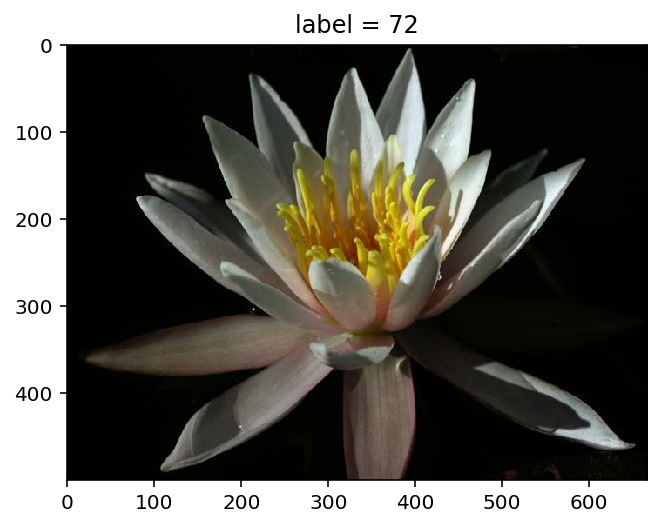

In [9]:
# TODO: Plot 1 image from the training set. 
# Set the title of the plot to the corresponding image label. 
for image, label in training_set.take(1):
    image = image.numpy()
    label = label.numpy()

plt.imshow(image)
label_title = 'label = {0}'.format(label)
plt.title(label_title)
plt.show()

### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [10]:
#with open('label_map.json', 'r') as f:
#    class_names = json.load(f)


# I copied the class names from the oxfor_flowers102 dataset's github sourcecode
# https://github.com/tensorflow/datasets/blob/master/tensorflow_datasets/image_classification/oxford_flowers102.py
class_names = [
    "pink primrose", "hard-leaved pocket orchid", "canterbury bells",
    "sweet pea", "english marigold", "tiger lily", "moon orchid",
    "bird of paradise", "monkshood", "globe thistle", "snapdragon",
    "colt's foot", "king protea", "spear thistle", "yellow iris",
    "globe-flower", "purple coneflower", "peruvian lily", "balloon flower",
    "giant white arum lily", "fire lily", "pincushion flower", "fritillary",
    "red ginger", "grape hyacinth", "corn poppy", "prince of wales feathers",
    "stemless gentian", "artichoke", "sweet william", "carnation",
    "garden phlox", "love in the mist", "mexican aster", "alpine sea holly",
    "ruby-lipped cattleya", "cape flower", "great masterwort", "siam tulip",
    "lenten rose", "barbeton daisy", "daffodil", "sword lily", "poinsettia",
    "bolero deep blue", "wallflower", "marigold", "buttercup", "oxeye daisy",
    "common dandelion", "petunia", "wild pansy", "primula", "sunflower",
    "pelargonium", "bishop of llandaff", "gaura", "geranium", "orange dahlia",
    "pink-yellow dahlia?", "cautleya spicata", "japanese anemone",
    "black-eyed susan", "silverbush", "californian poppy", "osteospermum",
    "spring crocus", "bearded iris", "windflower", "tree poppy", "gazania",
    "azalea", "water lily", "rose", "thorn apple", "morning glory",
    "passion flower", "lotus", "toad lily", "anthurium", "frangipani",
    "clematis", "hibiscus", "columbine", "desert-rose", "tree mallow",
    "magnolia", "cyclamen", "watercress", "canna lily", "hippeastrum",
    "bee balm", "ball moss", "foxglove", "bougainvillea", "camellia", "mallow",
    "mexican petunia", "bromelia", "blanket flower", "trumpet creeper",
    "blackberry lily"
]

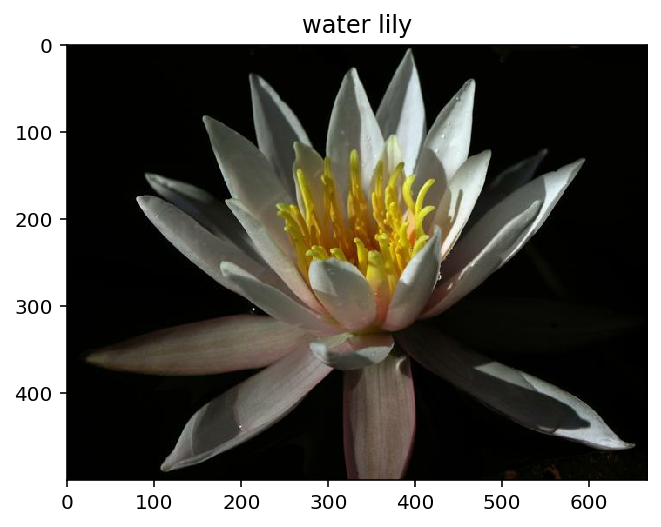

The label of this image is: 72
The class name of this image is: water lily


In [11]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 
for image, label in training_set.take(1):
    image = image.numpy()
    label = label.numpy()

plt.imshow(image)
plt.title(class_names[label])
plt.show()

print('The label of this image is:', label)
print('The class name of this image is:', class_names[label]) 
# add 1 to 'label' because the label in json starts the index from 1 instead of 0.
#print('The class name of this image is:', class_names[str(label+1)]) 

## Create Pipeline

In [12]:
# TODO: Create a pipeline for each set.
batch_size = 32
image_size = 224

def format_image(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    return image, label


training_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(batch_size).prefetch(1)
validation_batches = validation_set.map(format_image).batch(batch_size).prefetch(1)
testing_batches = test_set.map(format_image).batch(batch_size).prefetch(1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [32]:
# TODO: Build and train your network.

# load pre-trained model MobileNet_v2
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
image_size = 224
feature_extractor = hub.KerasLayer(URL, input_shape=(image_size, image_size,3))

# don't forget to freeze the parameter & bias so it is non-trainable
feature_extractor.trainable = False

In [29]:
from tensorflow import keras
class CustomModel(keras.Model):
    def __init__(self):
        super(CustomModel, self).__init__()

    def get_config(self):
        config = super(CustomModel, self).get_config()
        #config.update({
        #    'KerasLayer': self.att,
        #    'ffn': self.ffn,
        #})
        return config

In [30]:
custom_model = CustomModel(reloaded_keras_model)

TypeError: __init__() takes 1 positional argument but 2 were given

In [ ]:
# define a new model, add 1 dense layer + 1 dropout layer + 1 softmax layer
model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(200, activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(len(class_names), activation = 'softmax')
])
model.summary()

In [16]:
# compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Set early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# train the model
EPOCHS = 100
history = model.fit_generator(training_batches,
                              epochs=EPOCHS,
                              validation_data=validation_batches,
                              callbacks=[early_stopping])

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
32/32 [==============================] - ETA: 0s - loss: 4.4085 - accuracy: 0.0569WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f43facafa70> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
32/32 [==============================] - 48s 1s/step - loss: 4.4085 - accuracy: 0.0569 - val_loss: 3.7060 - val_accuracy: 0.2549
Epoch 2/100
32/3

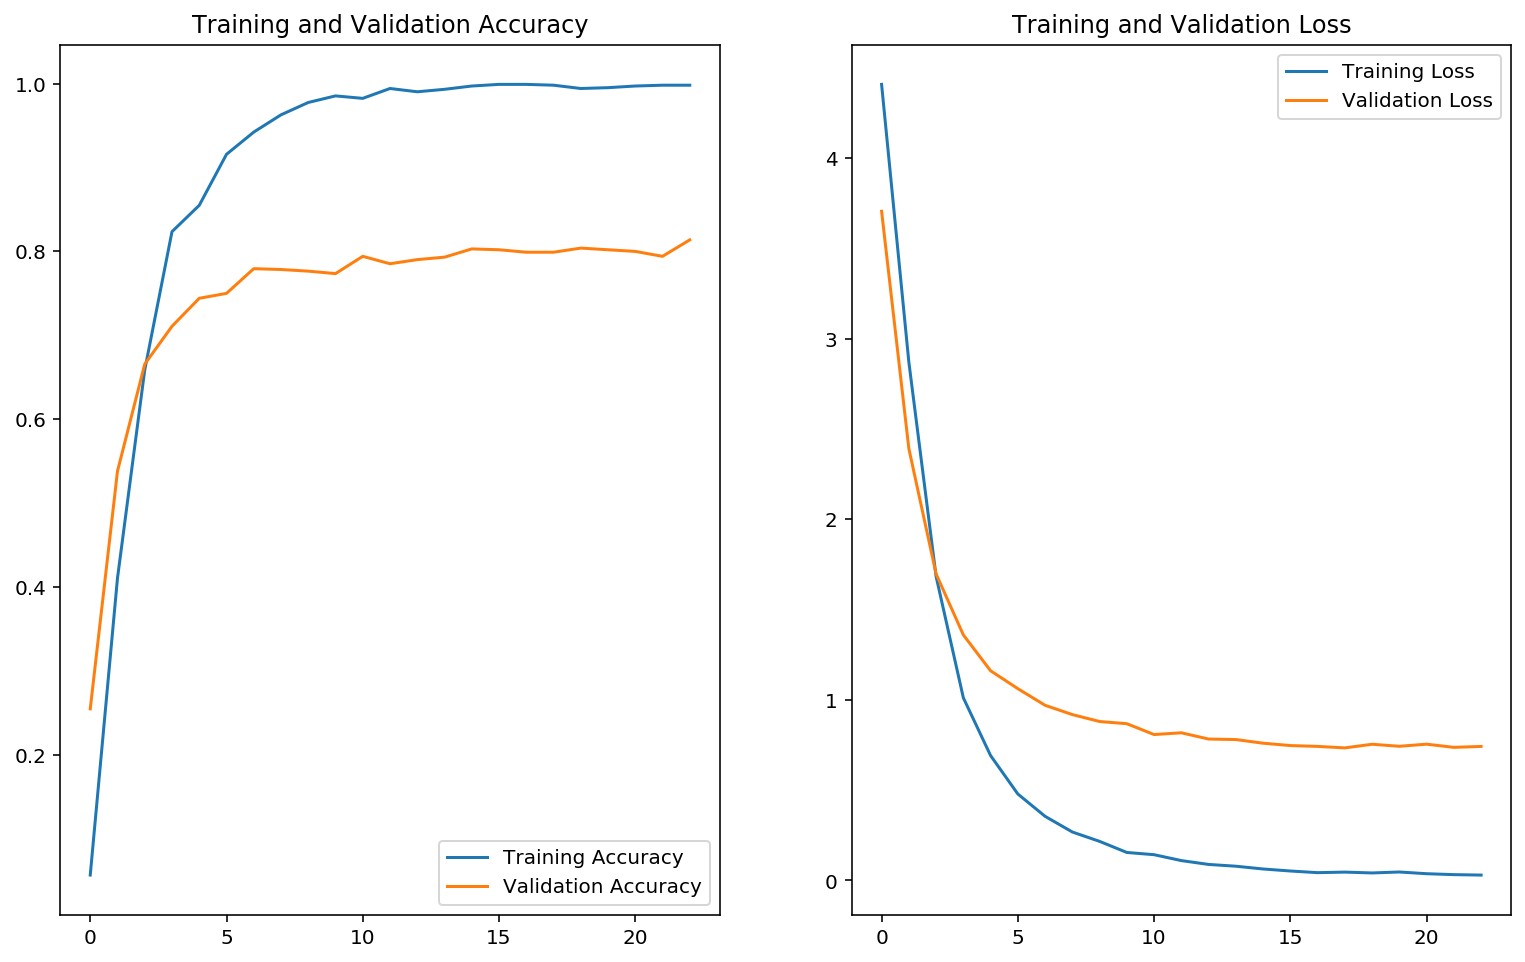

In [17]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(training_accuracy))

plt.figure(figsize=(13, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [18]:
# TODO: Print the loss and accuracy values achieved on the entire test set.
loss, accuracy = model.evaluate(testing_batches)

print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
print('Accuracy on the TEST Set: {:.3%}'.format(accuracy))

193/193 [==============================] - 125s 648ms/step - loss: 0.8908 - accuracy: 0.7770

Loss on the TEST Set: 0.891
Accuracy on the TEST Set: 77.704%


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [19]:
# TODO: Save your trained model as a Keras model.
t = time.time()
saved_keras_model_filepath = './{}.h5'.format(int(t))
model.save(saved_keras_model_filepath)

In [14]:
# 2022.05.22 
# I attempted to load the .h5 model and then save it as TensorFlow "SavedModel" format

# define save file name
import time
t = time.time()
tf_savedmodel_filepath = './tfmodel_{}'.format(int(t))
saved_keras_model_filepath = './1652514006.h5'

# load .h5 model, then save as SavedModel
reloaded_keras_model = tf.keras.models.load_model(saved_keras_model_filepath, custom_objects={"KerasLayer":feature_extractor})




#reloaded_keras_model.save(tf_savedmodel_filepath)

# load the SavedModel back
#from tensorflow import keras
#tf_model = keras.models.load_model(tf_savedmodel_filepath)

In [17]:
type(reloaded_keras_model)

keras.engine.sequential.Sequential

In [21]:
reloaded_keras_model.layers

In [18]:
type(reloaded_keras_model.get_config())

dict

## Load the Keras Model

Load the Keras model you saved above.

In [20]:
# TODO: Load the Keras model
reloaded_keras_model = tf.keras.models.load_model(saved_keras_model_filepath, custom_objects={"KerasLayer":feature_extractor})

# Test if the reloaded model has the same performance as the original one
for image_batch, label_batch in testing_batches.take(1):
    prediction_1 = model.predict(image_batch)
    prediction_2 = reloaded_keras_model.predict(image_batch)
    difference = np.abs(prediction_1 - prediction_2)
    print(difference.max())

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
0.0


# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [21]:
# TODO: Create the process_image function
from PIL import Image

def process_image(image_array):
  tf_im = tf.convert_to_tensor(image_array)
  tf_im = tf.image.resize(tf_im, (image_size, image_size))
  tf_im = tf.cast(tf_im, tf.float32)
  tf_im /= 255
  return tf_im.numpy()

To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

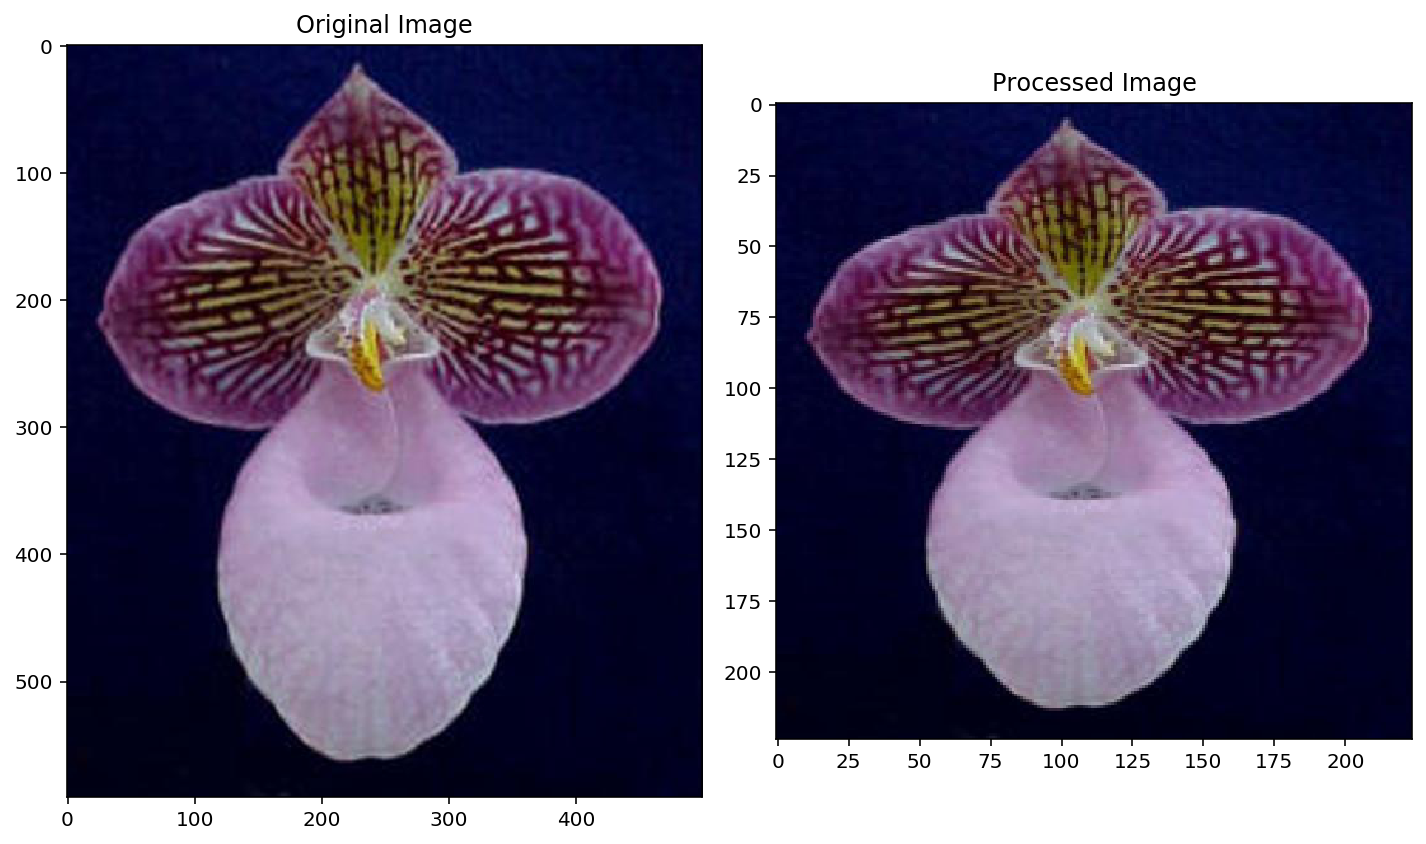

In [22]:
from PIL import Image

# read image
image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

# process it using the function defined above
processed_test_image = process_image(test_image)

# plot image - before and after processing
fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [23]:
# TODO: Create the predict function
def predict(image_path, model, top_k):
  with Image.open(image_path) as im:
    # convert image to numpy array then preprocess it
    im_arr = np.asarray(im)
    im_arr = process_image(im_arr)
    
    # expand dimension to convert array from shape (224,224,3) to (1,224,224,3)
    im_arr = np.expand_dims(im_arr, axis=0)

    # make prediction
    probs = model.predict(im_arr).flatten()

    # sort the index based on probabilities
    sorted_probs_index = np.argsort(probs)[::-1]
    top_probs_index = sorted_probs_index[:top_k]
    top_probs_value = probs[sorted_probs_index][:top_k]

    return top_probs_value, top_probs_index

# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

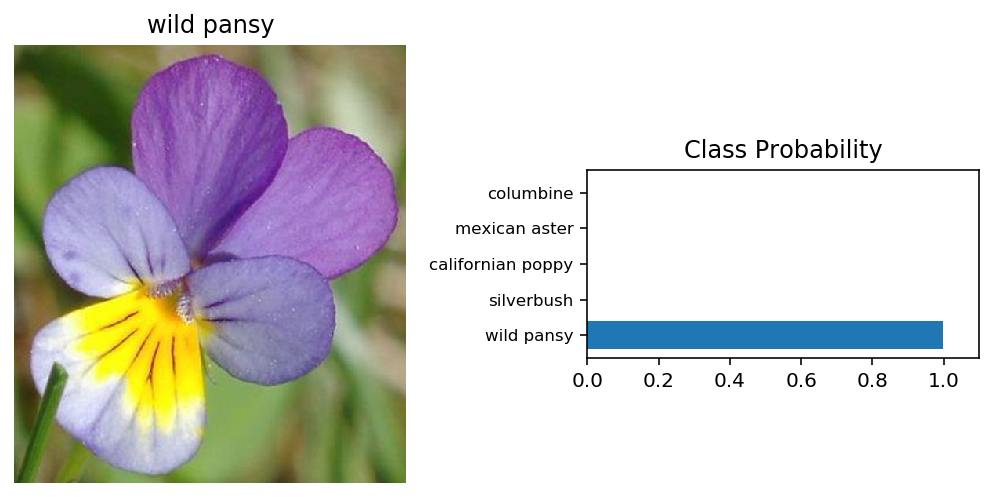

In [26]:
# TODO: Plot the input image along with the top 5 classes
# read image
test_images_dict = {'0':'cautleya_spicata','1':'hard-leaved_pocket_orchid','2':'orange_dahlia','3':'wild_pansy'}
image_path = './test_images/{0}.jpg'.format(test_images_dict['3'])
im = Image.open(image_path)
im_array = np.asarray(im)

# make prediction
top_k = 5
probs, classes = predict(image_path, model, top_k)
labels = [class_names[i] for i in classes.tolist()]

# plot the image and probabilities
fig, (ax1, ax2) = plt.subplots(figsize=(7,13), ncols=2)
ax1.imshow(im_array)
ax1.axis('off')
ax1.set_title(class_names[classes[0]])
ax2.barh(np.arange(top_k), probs)
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(top_k))
ax2.set_yticklabels(labels, size='small');
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()